# Advanced Lane-Finding

---
## Distortion Correction

![Distortion Correction](./images/Distortion_Correction.png)


![Radial distortion](./images/Radial_distortion.png)
![Radial distortion coefficients](./images/Radial_distortion_coefficients.png)


![Tangential distortion](./images/Tangential_distortion.png)
![Tangential distortion coefficients](./images/Tangential_distortion_coefficients.png)

### Import

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Matplotlib 功能
`%matplotlib qt  # show matplotlib in interactive window`

## CH1 Finding Corners

Using Opencv functions
```python3
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
```

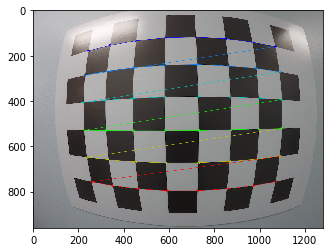

In [5]:
# prepare object points
nx = 8#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Make a list of calibration images
fname = './images/calibration_test.jpg'
img = cv2.imread(fname)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)


In [13]:
np.array([corners[i] for i in [0, 7, 40, 47]])

array([[[ 244.7138 ,  178.63393]],

       [[1069.2537 ,  161.26295]],

       [[ 258.032  ,  756.28784]],

       [[1069.9795 ,  755.50964]]], dtype=float32)

## CH2 Correcting for Distortion

```python3
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
```

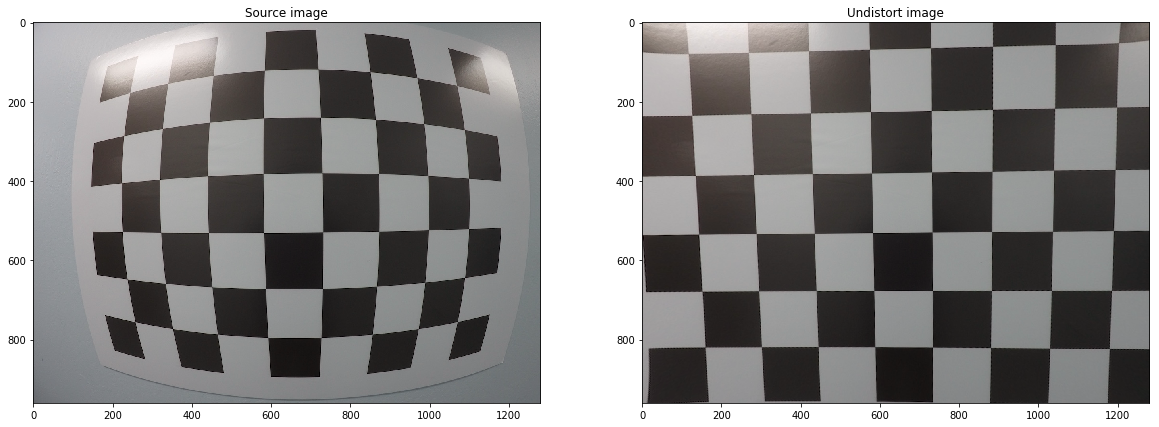

In [4]:
%matplotlib inline

# prepare object points
nx = 8
ny = 6

# Make a list of calibration images
fname = './images/calibration_test.jpg'
img = cv2.imread(fname)

# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image space

# Prepare object points, like (0,0,0) (1,0,0) (2,0,0) ... (7,5,0) (x,y,z)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2) # x,y,coordinates

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    
    ax1.set_title('Source image')
    ax1.imshow(img)
    ax2.set_title('Undistort image')
    ax2.imshow(dst)

## More Challenge

github: https://github.com/udacity/CarND-Camera-Calibration


這裡有37張照片，收集37張的imgpoints，
並計算出Distortion Coefficients，來校正照片。

---

## Sobel

```
1) Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
2) Take the derivative in x or y given orient = 'x' or 'y'
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
3) Take the absolute value of the derivative or gradient
abs_sobelx = np.absolute(sobelx)
4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
5) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
binary_output = np.zeros_like(scaled_sobel)
binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
```